In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
import math
import os
from librosa import display
import librosa
plt.rcParams['figure.figsize'] = 15, 8
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn as sk
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings("ignore")
from timeit import default_timer as timer

In [2]:
with open('all_features_data.p', 'rb') as f:
    vgg_data = pickle.load(f)


In [3]:
vgg_data.head(1)

,features,label,file_name,fold,salience,class,0,1,2,3,...,886,887,888,889,890,891,892,893,894,895
0,"[157.5, 12.5, 163.5, 111.25, 182.25, 32.5, 89....",3,UrbanSound8K/audio/fold1/101415-3-0-2.wav,1,1,dog_bark,157.5,12.5,163.5,111.25,...,0.0,0.922422,-0.502428,-0.341933,0.0,1.154701,-0.99787,0.0,-0.054023,0.0


In [4]:
vgg_data.shape

(8275, 902)

In [5]:
vgg_data['label']  = vgg_data['label'].astype('int64')

## Train Test Split

In [6]:
X = list(vgg_data['features'])
X = pd.DataFrame(X)
data_cols = X.columns
y=vgg_data['label']  

In [7]:
X.shape,y.shape

((8275, 896), (8275,))

In [8]:
test_preds = {}
X_train = X[0:6692].values
X_test = X[6692:].values
y_train = y[0:6692].values
y_test = y[6692:].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6692, 896), (1583, 896), (6692,), (1583,))

In [9]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:

#reshaping to 2D 
X_train=np.reshape(X_train,(X_train.shape[0], 64,14,1))
X_test=np.reshape(X_test,(X_test.shape[0], 64,14,1))
X_train.shape,X_test.shape

((6692, 64, 14, 1), (1583, 64, 14, 1))

In [11]:

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

validation_data = (x_val, y_val)

In [12]:
size_flat = 896
shape_full = (64, 14, 1)

shape_data = (64, 14)

num_channels = 1
num_classes = 10

#### Hyperparamter Tuning with Sci-Kit Optimize

In order to optimize the Convolutional Neural Network in classifying the audio data accurately, we need to find the following hyper-parameters:

- The learning-rate of the optimizer.
- The number of fully-connected / dense layers.
- The number of nodes for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

We will use the Python package scikit-optimize (or skopt) for finding the best choices of these hyper-parameters. Before we begin with the actual search for hyper-parameters, we first need to define the valid search-ranges or search-dimensions for each of these parameters.

Special thanks to Erik Hvass Pedersen for a detailed tutorial on Youtube and GitHub.

The below helper functions and code has been borrowed from [Hvass-Labs](https://www.hvass-labs.org/) **>** TensorFlow-Tutorials **>** 19_Hyper-Parameters

Please click the link for the video tutorial.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=oaxf3rk0KGM
" target="_blank"><img src="http://img.youtube.com/vi/oaxf3rk0KGM/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

##### Search Dimensions

This is the search-dimension for the learning-rate. It is a real number (floating-point) with a lower bound of 1e-6 and an upper bound of 1e-2. But instead of searching between these bounds directly, we use a logarithmic transformation, so we will search for the number k in 1ek which is only bounded between -6 and -2. This is better than searching the entire exponential range.

In [13]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=16, high=512, name='num_dense_nodes')

dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

In [14]:
# We then combine all these search-dimensions into a list.
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

default_parameters = [1e-3, 1, 128, 'relu']

##### Helper-function for log-dir-name

We will log the training-progress for all parameter-combinations so they can be viewed and compared using TensorBoard. This is done by setting a common parent-dir and then have a sub-dir for each parameter-combination with an appropriate name.

In [15]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

##### Helper-function for Create the Model

We first need a function that takes a set of hyper-parameters and creates the Convolutional Neural Network corresponding to those parameters. 

In [16]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the dim-size.
    # model.add(InputLayer(input_shape=(size_flat,)))

    # The input from VGG is a flattened array with 896 elements,
    # but the convolutional layers expect VGG with shape (64, 14, 1)
    # model.add(Reshape(shape_full))

    # First convolutional layer. We are making this as an input layer
    # Modified the layer as Input layer with shape (64, 14, 1) 
    # to avoid value valueError: 
    # You are trying to load a weight file containing 4 layers into a model with 0 layers site:stackoverflow.com
    
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1', input_shape=shape_full))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    # We will use Sparse Categorical Cross Entropy since we are not doing one-hot
    # encoding on the "class"
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

##### Train and Evaluate the Model
The neural network with the best hyper-parameters is saved to disk so it can be reloaded later. This is the filename for the model.

In [17]:
path_best_model = 'cnn_best_model.keras'

This is the classification accuracy for the model saved to disk. It is a global variable which will be updated during optimization of the hyper-parameters.

In [18]:
best_accuracy = 0.0

This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its performance on the validation-set. The function then returns the so-called fitness value (aka. objective value), which is the negative classification accuracy on the validation-set. It is negative because skopt performs minimization instead of maximization.

Note the function decorator @use_named_args which wraps the fitness function so that it can be called with all the parameters as a single list, for example: fitness(x=[1e-4, 3, 256, 'relu']). This is the calling-style skopt uses internally.

In [19]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=5,  
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
       
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [20]:
# Test Run
# Before we run the hyper-parameter optimization, let us first check that the various functions 
# above actually work, when we pass the default hyper-parameters.
fitness(x=default_parameters)

learning rate: 1.0e-03
num_dense_layers: 1
num_dense_nodes: 128
activation: relu

Instructions for updating:
Colocations handled automatically by placer.
Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [==============================] - 7s 1ms/sample - loss: 1.4479 - acc: 0.5214 - val_loss: 1.0445 - val_acc: 0.6731
Epoch 2/5
6022/6022 [==============================] - 6s 976us/sample - loss: 0.7461 - acc: 0.7554 - val_loss: 0.7444 - val_acc: 0.7627
Epoch 3/5
6022/6022 [==============================] - 5s 906us/sample - loss: 0.5501 - acc: 0.8250 - val_loss: 0.6130 - val_acc: 0.8075
Epoch 4/5
6022/6022 [==============================] - 6s 960us/sample - loss: 0.4286 - acc: 0.8637 - val_loss: 0.8160 - val_acc: 0.7493
Epoch 5/5
6022/6022 [==============================] - 6s 944us/sample - loss: 0.3788 - acc: 0.8804 - val_loss: 0.5077 - val_acc: 0.8478

Accuracy: 84.78%



-0.8477612

*Test run with default parameters (1e-3, 1, 128, 'relu') gave an accuracy of 84.78%*

##### Run the Hyper-Parameter Optimization

Now we are ready to run the actual hyper-parameter optimization using Bayesian optimization from the scikit-optimize package. Note that it first calls fitness() with default_parameters as the starting point we have found by hand-tuning, which should help the optimizer locate better hyper-parameters faster.

In [21]:
# Run the Hyper-Parameter Optimization
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-03
num_dense_layers: 1
num_dense_nodes: 128
activation: relu

Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [==============================] - 6s 1ms/sample - loss: 1.4546 - acc: 0.5188 - val_loss: 0.9355 - val_acc: 0.7090
Epoch 2/5
6022/6022 [==============================] - 7s 1ms/sample - loss: 0.7367 - acc: 0.7645 - val_loss: 0.8398 - val_acc: 0.7060
Epoch 3/5
6022/6022 [==============================] - 6s 1ms/sample - loss: 0.5413 - acc: 0.8268 - val_loss: 0.6675 - val_acc: 0.7881
Epoch 4/5
6022/6022 [==============================] - 6s 931us/sample - loss: 0.4366 - acc: 0.8584 - val_loss: 0.5068 - val_acc: 0.8358
Epoch 5/5
6022/6022 [==============================] - 6s 950us/sample - loss: 0.3210 - acc: 0.9030 - val_loss: 0.5552 - val_acc: 0.8254

Accuracy: 82.54%

learning rate: 2.3e-04
num_dense_layers: 2
num_dense_nodes: 250
activation: relu

Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [=======================

6022/6022 [==============================] - 9s 1ms/sample - loss: 2.2277 - acc: 0.1314 - val_loss: 2.1998 - val_acc: 0.1836

Accuracy: 18.36%

learning rate: 9.4e-06
num_dense_layers: 1
num_dense_nodes: 434
activation: relu

Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [==============================] - 11s 2ms/sample - loss: 2.3189 - acc: 0.1428 - val_loss: 2.2248 - val_acc: 0.2179
Epoch 2/5
6022/6022 [==============================] - 11s 2ms/sample - loss: 2.1680 - acc: 0.2496 - val_loss: 2.1274 - val_acc: 0.2716
Epoch 3/5
6022/6022 [==============================] - 9s 2ms/sample - loss: 2.0820 - acc: 0.3296 - val_loss: 2.0500 - val_acc: 0.3358
Epoch 4/5
6022/6022 [==============================] - 9s 2ms/sample - loss: 2.0057 - acc: 0.4004 - val_loss: 1.9771 - val_acc: 0.3910
Epoch 5/5
6022/6022 [==============================] - 9s 2ms/sample - loss: 1.9287 - acc: 0.4406 - val_loss: 1.9038 - val_acc: 0.4552

Accuracy: 45.52%

learning rate: 1.0e-02
num_dens

6022/6022 [==============================] - 8s 1ms/sample - loss: 2.3983 - acc: 0.0395 - val_loss: 2.4113 - val_acc: 0.0269
Epoch 5/5
6022/6022 [==============================] - 8s 1ms/sample - loss: 2.3979 - acc: 0.0395 - val_loss: 2.4108 - val_acc: 0.0269

Accuracy: 2.69%

learning rate: 5.1e-04
num_dense_layers: 2
num_dense_nodes: 512
activation: relu

Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [==============================] - 10s 2ms/sample - loss: 1.5055 - acc: 0.4867 - val_loss: 1.1168 - val_acc: 0.6403
Epoch 2/5
6022/6022 [==============================] - 9s 1ms/sample - loss: 0.7876 - acc: 0.7506 - val_loss: 0.7402 - val_acc: 0.7657
Epoch 3/5
6022/6022 [==============================] - 10s 2ms/sample - loss: 0.5589 - acc: 0.8251 - val_loss: 0.6207 - val_acc: 0.7896
Epoch 4/5
6022/6022 [==============================] - 12s 2ms/sample - loss: 0.4024 - acc: 0.8771 - val_loss: 0.7526 - val_acc: 0.7537
Epoch 5/5
6022/6022 [=============================

6022/6022 [==============================] - 9s 1ms/sample - loss: 0.4509 - acc: 0.8579 - val_loss: 0.4847 - val_acc: 0.8358
Epoch 4/5
6022/6022 [==============================] - 9s 2ms/sample - loss: 0.3118 - acc: 0.9007 - val_loss: 0.4762 - val_acc: 0.8403
Epoch 5/5
6022/6022 [==============================] - 10s 2ms/sample - loss: 0.2482 - acc: 0.9231 - val_loss: 0.4074 - val_acc: 0.8537

Accuracy: 85.37%

learning rate: 1.0e-03
num_dense_layers: 3
num_dense_nodes: 493
activation: relu

Train on 6022 samples, validate on 670 samples
Epoch 1/5
6022/6022 [==============================] - 14s 2ms/sample - loss: 1.5488 - acc: 0.4372 - val_loss: 1.0051 - val_acc: 0.6657
Epoch 2/5
6022/6022 [==============================] - 17s 3ms/sample - loss: 0.7054 - acc: 0.7589 - val_loss: 0.6350 - val_acc: 0.7970
Epoch 3/5
6022/6022 [==============================] - 12s 2ms/sample - loss: 0.4631 - acc: 0.8489 - val_loss: 0.6361 - val_acc: 0.7806
Epoch 4/5
6022/6022 [===========================

6022/6022 [==============================] - 5s 901us/sample - loss: 1.1259 - acc: 0.6141 - val_loss: 1.1456 - val_acc: 0.6075
Epoch 3/5
6022/6022 [==============================] - 6s 947us/sample - loss: 0.8038 - acc: 0.7330 - val_loss: 0.7572 - val_acc: 0.7582
Epoch 4/5
6022/6022 [==============================] - 6s 930us/sample - loss: 0.6191 - acc: 0.8055 - val_loss: 0.6294 - val_acc: 0.8060
Epoch 5/5
6022/6022 [==============================] - 5s 905us/sample - loss: 0.4846 - acc: 0.8476 - val_loss: 0.5486 - val_acc: 0.8269

Accuracy: 82.69%



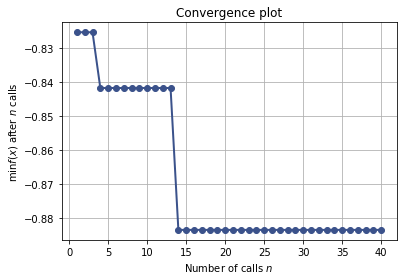

In [22]:
# Plot Optimization Progress
plot_convergence(search_result)

In [23]:
# Best Hyper-Parameters - learning_rate, num_dense_layers, num_dense_nodes, activation
search_result.x

[0.001014510076883394, 2, 425, 'relu']

This is the fitness value associated with these hyper-parameters. This is a negative number because the Bayesian optimizer performs minimization, so we had to negate the classification accuracy which is posed as a maximization problem.

In [24]:
search_result.fun

-0.8835821

We can also see all the hyper-parameters tried by the Bayesian optimizer and their associated fitness values (the negated classification accuracies). These are sorted so the highest classification accuracies are shown first.

It appears that 'relu' activation was generally better than 'sigmoid'. Otherwise it can be difficult to see a pattern of which parameter choices are good. 

In [25]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8835821, [0.001014510076883394, 2, 425, 'relu']),
 (-0.8731343, [0.001010068871389324, 3, 494, 'relu']),
 (-0.87014925, [0.0010002474362447373, 2, 512, 'relu']),
 (-0.8686567, [0.0008942821100629202, 1, 512, 'relu']),
 (-0.8641791, [0.0007889813790411765, 3, 512, 'relu']),
 (-0.8626866, [0.000511600933634934, 2, 512, 'relu']),
 (-0.8597015, [0.0010091528702974853, 3, 493, 'relu']),
 (-0.85373133, [0.000996377498042654, 1, 512, 'relu']),
 (-0.85373133, [0.001009686020196102, 1, 494, 'relu']),
 (-0.8477612, [0.0007563110656294147, 1, 318, 'relu']),
 (-0.8477612, [0.0012296182455304079, 1, 307, 'relu']),
 (-0.84179103, [0.0007381370203632925, 2, 452, 'relu']),
 (-0.84029853, [0.00036293391942834744, 2, 512, 'relu']),
 (-0.82835823, [0.0017843612182104063, 1, 16, 'relu']),
 (-0.8268657, [0.0017370653517178366, 1, 16, 'relu']),
 (-0.8253731, [0.001, 1, 128, 'relu']),
 (-0.8238806, [0.0017543563784785411, 1, 16, 'relu']),
 (-0.82238805, [0.0013425511369917409, 3, 512, 'relu']),
 (-0.805

##### Evaluate Best Model on Test-Set

We can now use the best model on the test-set. It is very easy to reload the model using Keras.

In [26]:
model = load_model(path_best_model)

In [27]:
result = model.evaluate(x=X_test,
                        y=y_test)

1583/1583 [==============================] - 1s 513us/sample - loss: 0.7621 - acc: 0.7991


In [28]:
predictions = model.predict_classes(X_test)

In [29]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.7621440312866915
acc 0.7991156


In [30]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 79.91%


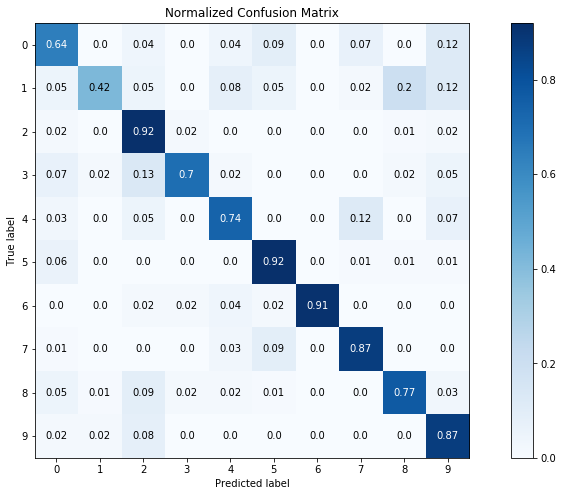

<Figure size 1080x576 with 0 Axes>

In [31]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
plt.savefig('CNN_SO_Confusion_Matrix.png')

We can just print the classification accuracy.

In [32]:
print('Test loss={}, Test accuracy={}'.format(result[0],result[1]))

Test loss=0.7621440312866915, Test accuracy=0.7991155982017517
